## DeepDAO and API requests

Here we learn how to make API requests and we refresh a bit of plotting.

In [6]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(pd.__version__)
print(np.__version__)
print(requests.__version__)
print(plt.matplotlib.__version__)


1.4.3
1.23.1
2.28.1
3.5.2


Import authentication key.

In [13]:
# https://martin-thoma.com/configuration-files-in-python/

import json

with open("../.private/keys.json") as keys_file:
    KEYS = json.load(keys_file)

APIKEY = KEYS['DEEPDAO']
# Note: don't print the key, or if you do, delete the cell's output
# (cell outputs are saved and can be sent to Github).

DeepDao Endpoint

In [14]:
ENDPOINT = 'https://api.deepdao.io/v0.1/'

Let's create a function to communicate with the REST endpoint. 

In [15]:
def api(query, params=None, post=False):

    # https://datagy.io/python-requests-authentication/
    headers={
        'x-api-key': APIKEY,
        'accept': 'application/json'
    }

    if post:
        response = requests.post(ENDPOINT + query,
                                headers=headers,
                                json=params)
    else:
        response = requests.get(ENDPOINT + query,
                                headers=headers,
                                params=params)

    print(response)
    return response.json()


Let's try our first DeepDao query.

In [16]:
query = "ecosystem"

res = api(query)

<Response [200]>


Any response code greater than 400 indicates an error, else it is a success. See:

https://developer.mozilla.org/en-US/docs/Web/HTTP/Status

In [17]:
 res


{'data': {'totalTreasury': 9847042577.650763,
  'governanceTokenHolders': 3935144,
  'activeMembers': '697984',
  'organizationsOver1MUsd': 110,
  'organizationsOver10MUsd': 61,
  'organizationsOver100MUsd': 16,
  'organizationsOver100GovTokenHolders': 674,
  'organizationsOver1kGovTokenHolders': 202,
  'organizationsOver10kGovTokenHolders': 61,
  'totalProposals': 67479,
  'totalVotes': 3864729},
 'apiAccountMetaData': {'endpoint': 'https://api.deepdao.io/v0.1/ecosystem',
  'origin': 'DeepDAO',
  'date': '2022-09-27T12:48:06.882Z'}}

Get all DAOs in DeepDAO.

In [18]:
query = "organizations"

res = api(query)

<Response [200]>


In [20]:
res

{'data': {'totalResources': 2276,
  'resources': [{'organizationId': '8b8eab40-2728-4b71-9498-383af5bbf31d',
    'name': 'hyaliko dao',
    'description': 'DeepDAO research coming soon',
    'logo': None,
    'members': 18,
    'activeMembers': '0',
    'proposals': 3,
    'votes': 23,
    'governance': [{'platform': 'SNAPSHOT',
      'id': '9f5c01b3-c7c7-4399-9c54-2fde9f19d5ce',
      'name': 'hyaliko dao',
      'address': 'hyaliko-dao.eth'}],
    'categories': None,
    'socialResources': [{'type': 'DISCORD',
      'urls': ['https://discord.com/invite/2xvCVkAuWu']},
     {'type': 'TWITTER', 'urls': ['https://twitter.com/hyaliko']},
     {'type': 'WEBSITE', 'urls': ['https://www.hyaliko.com/']}],
    'updatedAt': '2022-09-27T03:11:25.651Z'},
   {'organizationId': '8c3057f8-d43a-4fc2-989c-a613e83c5b52',
    'name': 'Bao Finance',
    'description': 'Bao Finance is a community-run project aiming to build a decentralized, open platform for synthetics linked to any data. Tokenizing data 

Save the list for future reference.

In [21]:
df = pd.DataFrame(res['data']['resources'])
df.to_json("data/daos_deepdao.json", orient="records")

## Visually explore the saved file.
# Is it a mess? Prettify it with VS Code auto-formatter. 
# Don't you remember the shorcut? Check our python_warmup lecture.

#### Example: fetch data, insert into data frame, clean it, and plot it.

Treasuries by chain.

In [22]:
query = "ecosystem/chains_treasury_breakdown"

res = api(query)

<Response [504]>


In [23]:
res

{'message': 'Endpoint request timed out'}

Convert the result into a data frame for easier plotting.

In [ ]:
df = pd.DataFrame()

for d in res['data']:
    df = df.append(res['data'][d], ignore_index=True)


df.info()

Shorten column names.

In [ ]:
df.columns = [
    'chainId', 'chainName', 'orgs', 'props', 'votes', 'treas', 'usd', 'holders'
]

df.info()


Format data.

In [ ]:
def cleanData(x):
    return 0 if x == 'N/A' else x.replace(',', '')
    
int_columns = ['orgs', 'props', 'votes', 'treas', 'usd', 'holders']
for col in int_columns:
    # print(col)
    # df[col] = df[col].apply(lambda x : x.replace(',', ''))
    df[col] = df[col].apply(cleanData)


In [ ]:
df['orgs'] = df['orgs'].astype('float')
df['props'] = df['props'].astype('float')
df['votes'] = df['votes'].astype('float')
df['treas'] = df['treas'].astype('float')
df['usd'] = df['usd'].astype('float')
df['holders'] = df['holders'].astype('float')



In [ ]:
df.info()

Plot it.

In [ ]:
import matplotlib.pyplot as plt

df['chain'] = df['chainName'].apply(lambda x : x[0:3])
df = df.set_index(df['chain'])


fig, axes = plt.subplots(nrows=2, ncols=4)

counter = 0
for c in int_columns:
    x = 0 if counter < 4 else 1 
    y = counter % 4
    # print(c, x, y)
    ax = df[["chain", c]].plot.bar(x="chain", y=c, ax=axes[x,y], figsize=(20,10))
    # ax.set_title(c)
    ax.set_xlabel('')
    counter += 1


More compact (but with less control).

In [ ]:
df[int_columns].plot.pie(subplots=True, figsize=(20,10))


#### A few more queries...

In [24]:
query = "ecosystem/gov_platforms"
res = api(query)

<Response [200]>


In [25]:
res

{'data': [{'platformId': 1, 'platformTitle': 'DAOstack'},
  {'platformId': 2, 'platformTitle': 'Moloch / Daohaus'},
  {'platformId': 3, 'platformTitle': 'OpenLaw'},
  {'platformId': 4, 'platformTitle': 'Aragon'},
  {'platformId': 5, 'platformTitle': 'Colony'},
  {'platformId': -1, 'platformTitle': 'AssetsOnly'},
  {'platformId': 11, 'platformTitle': 'snapshot'},
  {'platformId': 12, 'platformTitle': 'Safe/Snapshot'},
  {'platformId': 6, 'platformTitle': 'Compound'},
  {'platformId': 14, 'platformTitle': 'Realms'},
  {'platformId': 15, 'platformTitle': 'Substrate'}],
 'apiAccountMetaData': {'endpoint': 'https://api.deepdao.io/v0.1/ecosystem/gov_platforms',
  'origin': 'DeepDAO',
  'date': '2022-09-27T13:08:05.390Z'}}

In [ ]:
query = "proposals/active_proposals"
res = api(query, { 'page': 1 })

In [ ]:
res

#### Time Series

In [26]:
query = "timeseries/daily_proposals"
params = {
    'platforms': "11",
    'startDate': "2018-01-01",
    'endDate': "2022-09-01",
}
res = api(query, params)


<Response [200]>


In [27]:
res

[{'date': '2022-09-01', 'counter': 36},
 {'date': '2022-08-31', 'counter': 57},
 {'date': '2022-08-30', 'counter': 43},
 {'date': '2022-08-29', 'counter': 56},
 {'date': '2022-08-28', 'counter': 20},
 {'date': '2022-08-27', 'counter': 35},
 {'date': '2022-08-26', 'counter': 31},
 {'date': '2022-08-25', 'counter': 37},
 {'date': '2022-08-24', 'counter': 37},
 {'date': '2022-08-23', 'counter': 32},
 {'date': '2022-08-22', 'counter': 53},
 {'date': '2022-08-21', 'counter': 15},
 {'date': '2022-08-20', 'counter': 15},
 {'date': '2022-08-19', 'counter': 42},
 {'date': '2022-08-18', 'counter': 46},
 {'date': '2022-08-17', 'counter': 53},
 {'date': '2022-08-16', 'counter': 48},
 {'date': '2022-08-15', 'counter': 59},
 {'date': '2022-08-14', 'counter': 17},
 {'date': '2022-08-13', 'counter': 25},
 {'date': '2022-08-12', 'counter': 25},
 {'date': '2022-08-11', 'counter': 36},
 {'date': '2022-08-10', 'counter': 48},
 {'date': '2022-08-09', 'counter': 65},
 {'date': '2022-08-08', 'counter': 35},


In [28]:
df = pd.DataFrame(res)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')


In [29]:
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 738 entries, 2022-09-01 to 2020-08-24
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   counter  738 non-null    int64
dtypes: int64(1)
memory usage: 11.5 KB


<AxesSubplot:>

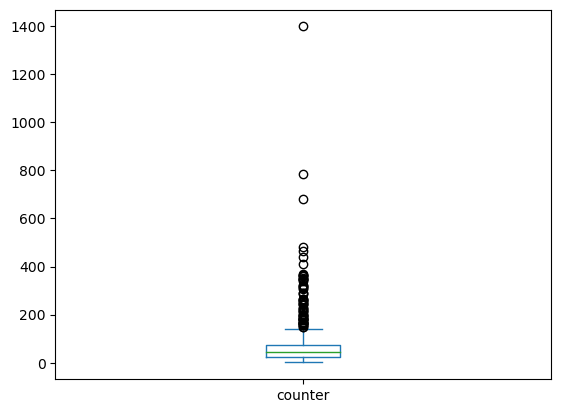

In [30]:
df.plot.box()


<AxesSubplot:xlabel='date'>

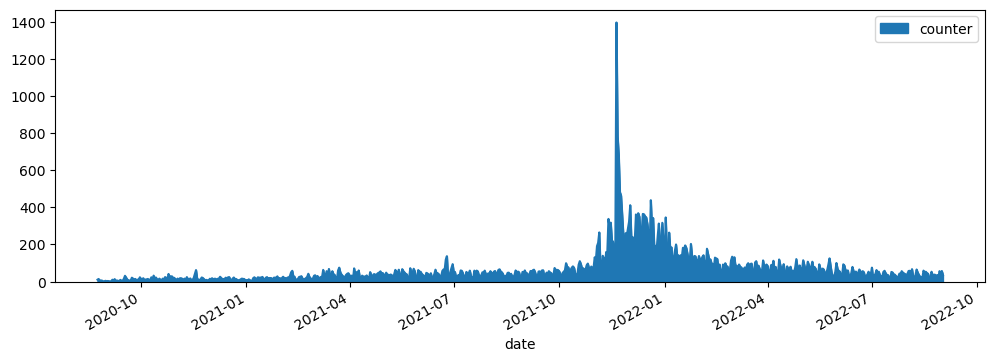

In [31]:
df.plot.area(figsize=(12, 4))

c:\Users\Administrator\anaconda3\envs\IS808\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<AxesSubplot:ylabel='Density'>

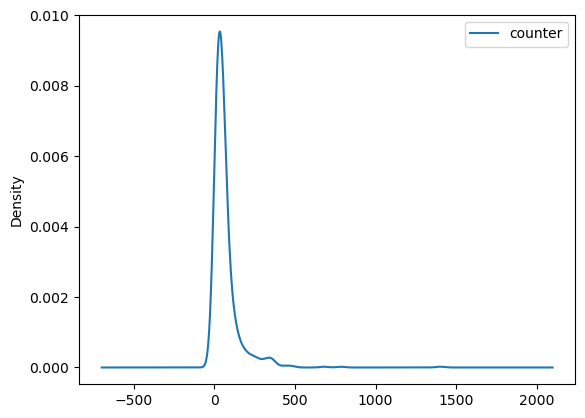

In [33]:
df.plot.density()

In [ ]:
df.plot.hist(bins=100)

In [ ]:
df.plot.line()

## Badger DAO

In [34]:
badgerDAO = "fe4cd05c-f6cb-461a-add9-bcdb1365fc0e"


In [35]:
query = "timeseries/daily_dao_proposals/" + badgerDAO

params = { 
    'startDate': "2018-01-01",
    'endDate': "2022-09-01",
}

res = api(query, params)

<Response [200]>


In [36]:
len(res)

78

In [37]:
res

[{'date': '2022-08-16', 'counter': 1},
 {'date': '2022-08-01', 'counter': 1},
 {'date': '2022-07-06', 'counter': 2},
 {'date': '2022-06-28', 'counter': 2},
 {'date': '2022-05-02', 'counter': 1},
 {'date': '2022-04-27', 'counter': 1},
 {'date': '2022-04-20', 'counter': 1},
 {'date': '2022-03-28', 'counter': 2},
 {'date': '2022-03-17', 'counter': 1},
 {'date': '2022-02-04', 'counter': 1},
 {'date': '2022-01-18', 'counter': 1},
 {'date': '2022-01-05', 'counter': 2},
 {'date': '2022-01-04', 'counter': 1},
 {'date': '2021-12-29', 'counter': 1},
 {'date': '2021-12-27', 'counter': 2},
 {'date': '2021-12-18', 'counter': 1},
 {'date': '2021-12-17', 'counter': 1},
 {'date': '2021-12-15', 'counter': 1},
 {'date': '2021-12-14', 'counter': 1},
 {'date': '2021-12-11', 'counter': 1},
 {'date': '2021-11-14', 'counter': 1},
 {'date': '2021-11-08', 'counter': 1},
 {'date': '2021-11-03', 'counter': 1},
 {'date': '2021-10-28', 'counter': 1},
 {'date': '2021-10-22', 'counter': 1},
 {'date': '2021-10-18', '

In [38]:
df_badger = pd.DataFrame(res)
df_badger['date'] = pd.to_datetime(df_badger['date'])
df_badger = df_badger.set_index('date')
df_badger.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78 entries, 2022-08-16 to 2020-12-20
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   counter  78 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


In [39]:
df_badger.describe()

,counter
count,78.000000
mean,1.743590
std,1.678248
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,10.000000


In [40]:
df_badger[df_badger['counter'] == df_badger['counter'].max()]

,counter
date,
2021-02-24,10


In [41]:
query = "timeseries/daily_dao_treasury/" + badgerDAO

params = { 
    'startDate': "2018-01-01",
    'endDate': "2022-09-01",
}

res = api(query, params)
len(res)

<Response [200]>


7

In [42]:
res

{'total': [{'date': '2022-09-01', 'aum': 23080659.369379885},
  {'date': '2022-08-31', 'aum': 22253743.980534416},
  {'date': '2022-08-30', 'aum': 21694949.31822275},
  {'date': '2022-08-29', 'aum': 22932966.41679944},
  {'date': '2022-08-28', 'aum': 22157716.427223794},
  {'date': '2022-08-27', 'aum': 21965304.21088102},
  {'date': '2022-08-26', 'aum': 23000876.83088723},
  {'date': '2022-08-25', 'aum': 24891915.48193446},
  {'date': '2022-08-24', 'aum': 23289274.544821322},
  {'date': '2022-08-23', 'aum': 22853639.471773814},
  {'date': '2022-08-22', 'aum': 22938338.66364345},
  {'date': '2022-08-21', 'aum': 23863228.59694742},
  {'date': '2022-08-20', 'aum': 22962467.363073893},
  {'date': '2022-08-19', 'aum': 22819990.37766436},
  {'date': '2022-08-18', 'aum': 25321818.222860154},
  {'date': '2022-08-17', 'aum': 25683052.526528332},
  {'date': '2022-08-16', 'aum': 26943271.477129795},
  {'date': '2022-08-15', 'aum': 27733576.80739295},
  {'date': '2022-08-14', 'aum': 27903487.92577

In [43]:
df_badger_treasury = pd.DataFrame(res['liquid'])
df_badger_treasury['date'] = pd.to_datetime(df_badger_treasury['date'])
df_badger_treasury = df_badger_treasury.set_index('date')
df_badger_treasury.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98 entries, 2022-09-01 to 2021-12-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aum     98 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


<AxesSubplot:xlabel='date'>

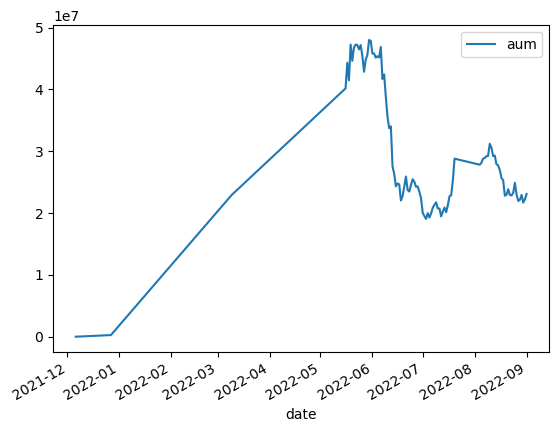

In [44]:
df_badger_treasury.plot()

In [ ]:
df_badger = df_badger.join(df_badger_treasury, how="outer")

In [ ]:
df_badger.head()

In [ ]:
df_badger.info()

In [ ]:
df
df.plot(x=df.index, y=["counter", "aum"])

In [47]:
query = "proposal/active_proposals/"
params = { 
    'page' : 2
}
res = api(query, params)


<Response [404]>


In [48]:
res

{'statusCode': 404,
 'message': 'Cannot GET /docs/proposal/active_proposals?page=2',
 'timestamp': 'Tue, 27 Sep 2022 13:27:05 GMT',
 'path': '/docs/proposal/active_proposals?page=2'}